# Автоэнкодеры (автокодировщики) 
__Автоенкодеры (автокодировщики) англ. _autoencoder___ --специальная архитектура нейронной сети, предназначенная для обучения сжатых (как правило) представлений наборов данных. Автоэнкодер состоит из двух соединенных нейронных сетей: модели энкодера (кодировщика) и модели декодера (декодировщика). 
Распространненные варианты автроэнкодеров:
* Сжимающие автоэнкодеры.
* Шумоподавляющие автоэнкодеры
* Вариационные автоэнкодеры (_variational  autoencoder - VAE_).

В практическом занятии используются материалы:


1. Building Autoencoders in [Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
2. [Автоэнкодеры: типы архитектур и применение](https://neurohive.io/ru/osnovy-data-science/avtojenkoder-tipy-arhitektur-i-primenenie/)
3. Y. Chen , E. Keogh.  [Dataset=ECG5000](https://www.timeseriesclassification.com/description.php?Dataset=ECG5000)
4.  Введение в автоэнкодеры.[Обнаружение аномалий.](https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ru)

In [157]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

import pandas as pd
# use seaborn plotting defaults
import seaborn as sns; sns.set()
sns.set(style="whitegrid")

import json
import random
import numpy as np
import pandas as pd
import cv2

from pandas import date_range, Series, DataFrame, read_csv, qcut
from numpy.random import randn


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, utils
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Convolution2DTranspose, concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing import image


## Простейшие автоэнкодеры

### Данные (MNIST)

In [158]:
from tensorflow.keras.datasets import mnist

In [173]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

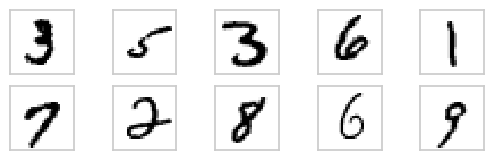

In [174]:
for i in range(10, 20):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i], cmap=plt.cm.binary, interpolation='nearest')

In [175]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

### Простейший автоэнкодер

In [89]:
import keras
from keras import layers

In [90]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [91]:
autoencoder.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [93]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

### Компиляция и обучение простейшего автоэнкодера

In [12]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3815 - val_loss: 0.1941
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1832 - val_loss: 0.1540
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1496 - val_loss: 0.1334
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1314 - val_loss: 0.1206
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1197 - val_loss: 0.1125
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1124 - val_loss: 0.1068
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1072 - val_loss: 0.1027
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1030 - val_loss: 0.0996
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1002 - val_loss: 0.0973
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0983 - val_loss: 0.0958
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0968 - val_loss: 0.0947
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

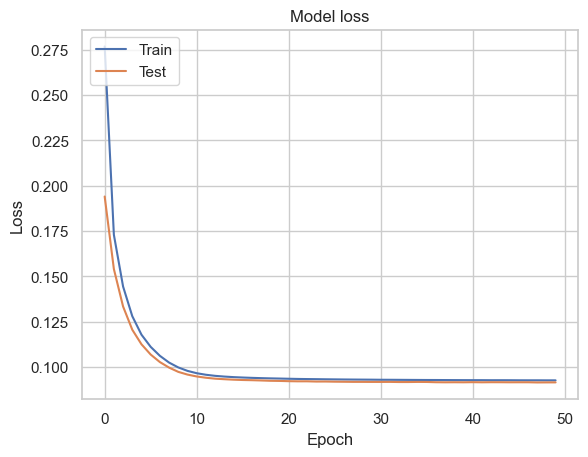

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [50]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


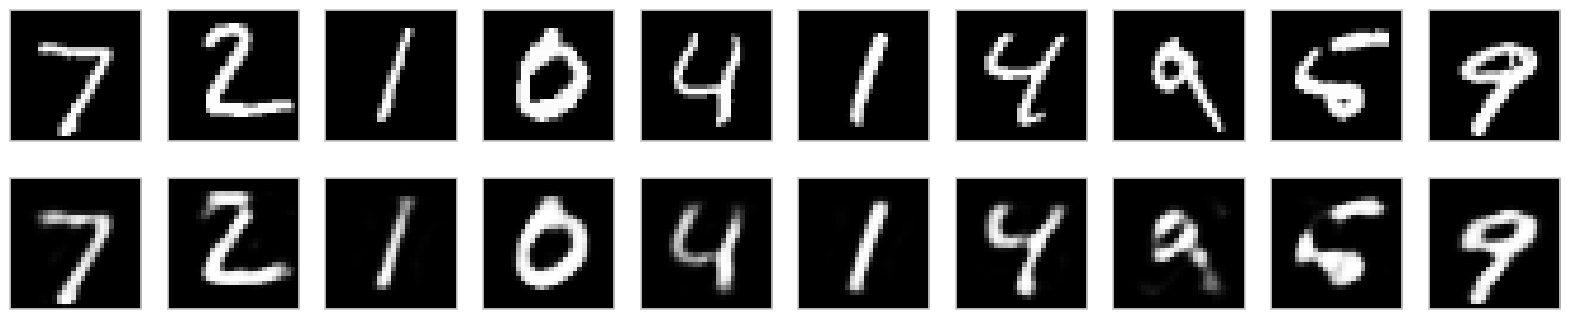

In [51]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Добавление разреженностии. L1-ограничение

Добавление ограничения разреженности к закодированному представлению (L1-регуляризация)

__Посмотреть:__
* [Ridge](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html)
* [Лассо](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.Lasso.html)

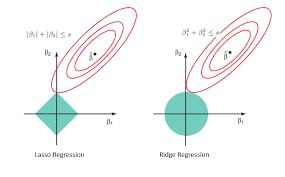

In [94]:
encoding_dim = 32

input_img2 = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded2 = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img2)
decoded2 = layers.Dense(784, activation='sigmoid')(encoded2)

autoencoder2 = keras.Model(input_img2, decoded2)

### Компиляция и обучение автоэнкодера с l1-разреженностью

In [61]:
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

In [62]:
history = autoencoder2.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6813 - val_loss: 0.6155
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5987 - val_loss: 0.5535
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5399 - val_loss: 0.5038
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4928 - val_loss: 0.4638
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4550 - val_loss: 0.4314
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4239 - val_loss: 0.4050
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3987 - val_loss: 0.3834
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3783 - val_loss: 0.3656
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3614 - val_loss: 0.3508
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3473 - val_loss: 0.3385
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3356 - val_loss: 0.3281
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━

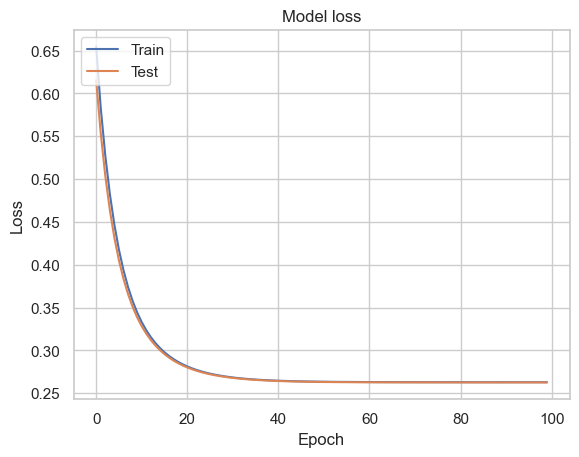

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [81]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


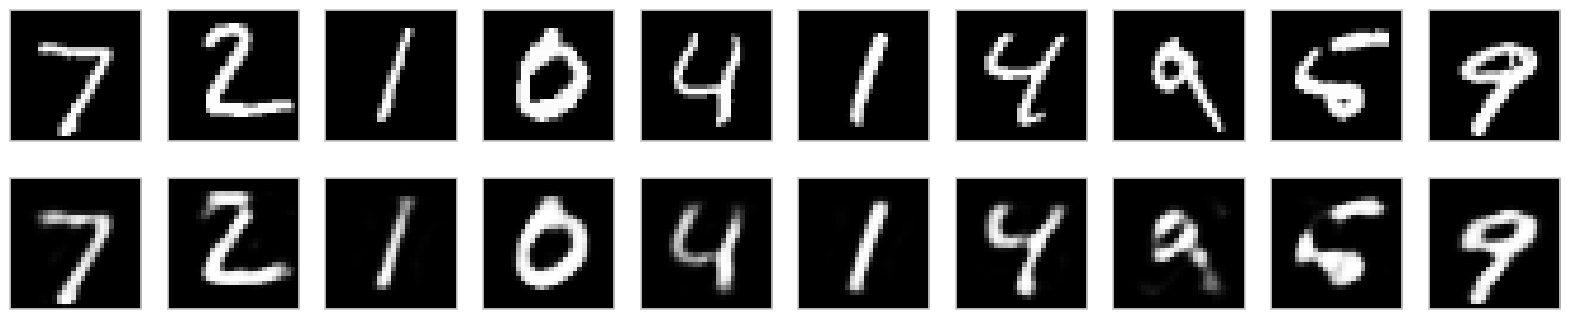

In [82]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [83]:
encoded_imgs.mean()

9.010628

### Многослойный автоэнкодер

In [67]:
input_img3 = keras.Input(shape=(784,))
encoded3 = layers.Dense(128, activation='relu')(input_img3)
encoded3 = layers.Dense(64, activation='relu')(encoded3)
encoded3 = layers.Dense(32, activation='relu')(encoded3)

decoded3 = layers.Dense(64, activation='relu')(encoded3)
decoded3 = layers.Dense(128, activation='relu')(decoded3)
decoded3 = layers.Dense(784, activation='sigmoid')(decoded3)
autoencoder3 = keras.Model(input_img3, decoded3)

In [68]:
autoencoder3.compile(optimizer='adam', loss='binary_crossentropy')

### Компиляция и обучение многослойного автоэнкодера

In [69]:
history = autoencoder3.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3468 - val_loss: 0.1767
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1668 - val_loss: 0.1411
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1379 - val_loss: 0.1267
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1262 - val_loss: 0.1193
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1195 - val_loss: 0.1150
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1156 - val_loss: 0.1117
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1124 - val_loss: 0.1085
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1092 - val_loss: 0.1063
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1070 - val_loss: 0.1039
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1046 - val_loss: 0.1023
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1028 - val_loss: 0.1003
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━

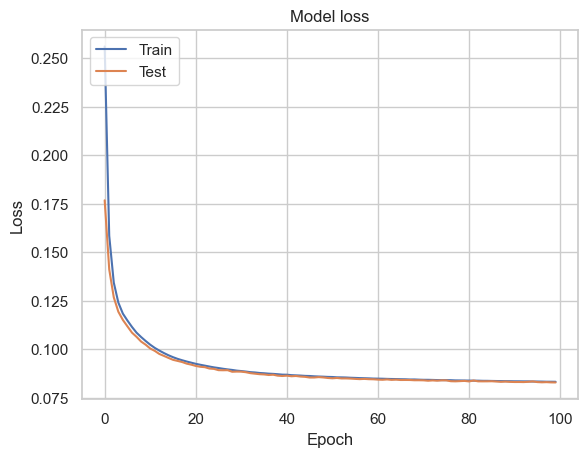

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [71]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


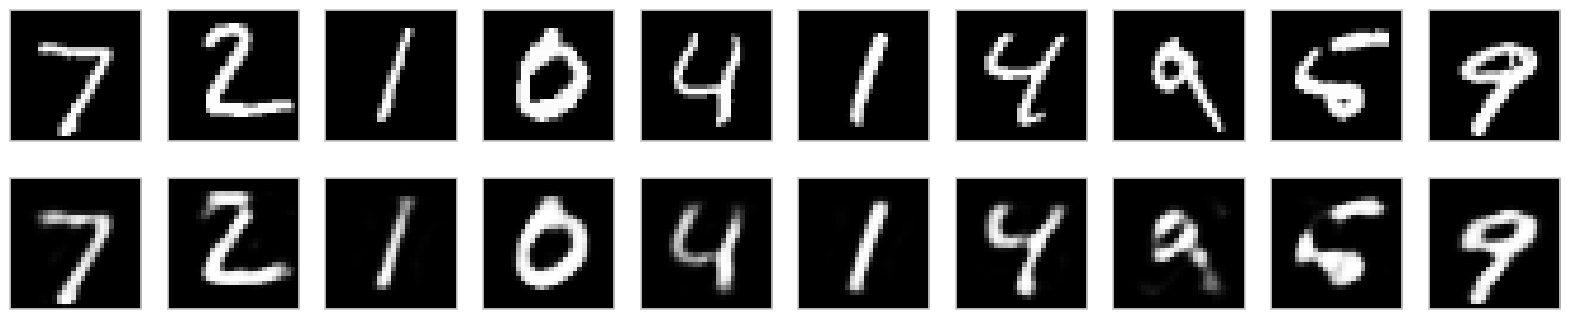

In [84]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Поиск аномалий

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [73]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [74]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [75]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [76]:
x_plt = np.arange(0, data.shape[1], 1)
y = data[0]

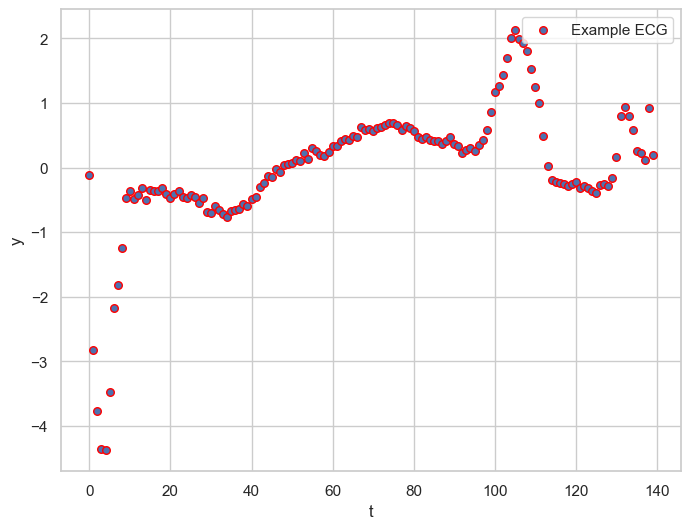

In [77]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(x_plt , y, edgecolor="red", s=30, label='Example ECG')
plt.xlabel('t', size=12)
plt.ylabel('y', size=12)
plt.legend(loc='upper right')
plt.show()

### Нормирование данных

In [79]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

### Разделение на тренировочную и тестовую выборки
Для обучения используются только нормальные ЭКГ (помеченные 1).

In [80]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

### Нормальная и аномальная ЭКГ

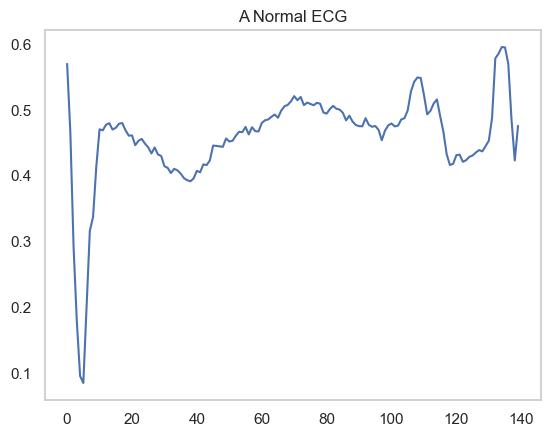

In [86]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

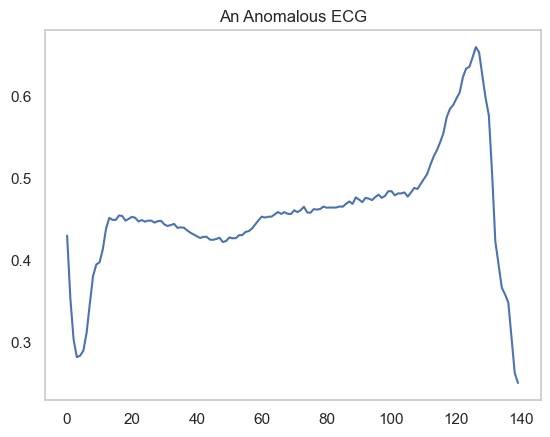

In [87]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Инициализация модели-автоэнкодера

In [97]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

### Компиляция и обучение автоэнкодера для поиска аномалий

In [98]:
autoencoder.compile(optimizer='adam', loss='mae')

In [99]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0582 - val_loss: 0.0533
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0561 - val_loss: 0.0517
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0534 - val_loss: 0.0498
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0498 - val_loss: 0.0474
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0460 - val_loss: 0.0452
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0423 - val_loss: 0.0431
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0387 - val_loss: 0.0413
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - val_loss: 0.0398
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0325 - val_loss: 0.0385
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0302 - val_loss: 0.0377
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0282 - val_loss: 0.0368
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267 - val_loss: 0.0358
Epoch 13/20

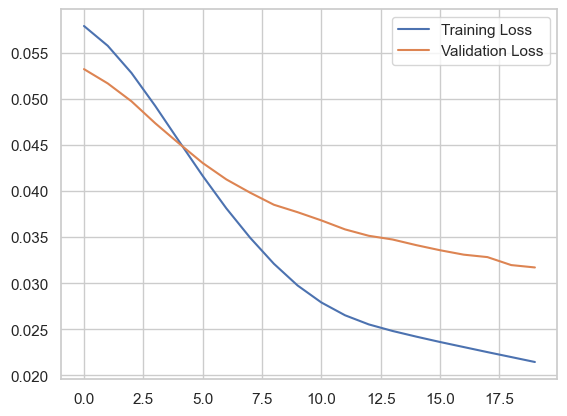

In [100]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Демонстрация восстановления ЭКГ декодером и разницы с изначальной нормальной и аномальной ЭКГ

Признаком отклонения от нормы - аномальной ЭКГ - является отклонение действительной ЭКГ от восстановленной более чем на 1 стандартное отклонение.

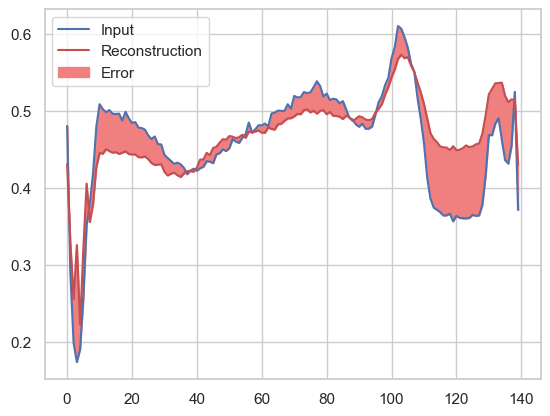

In [103]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

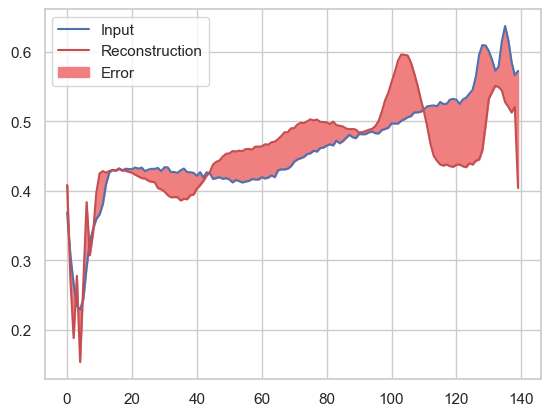

In [104]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Обнаружение аномалий

Построив гистограмму ошибок для нормальных и аномальных ЭКГ можно обнаружить, что большинство нормальных и аномальных ЭКГ можно разграничить некоторым пороговым значением. Это значение задается, согласно туториалу, как сумма средней ошибки и одного стандартного отклонения.

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


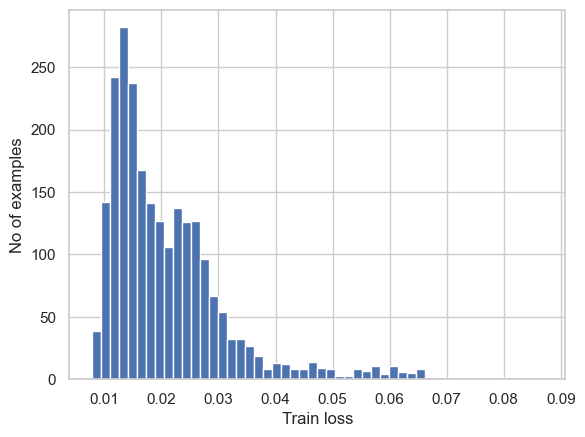

In [108]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [109]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032141484


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


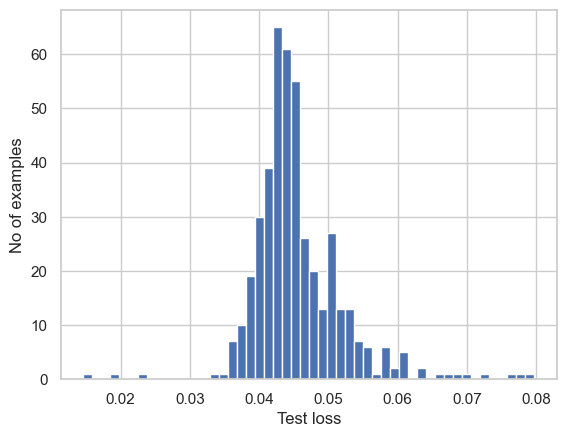

In [110]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

### Функция обнаружения аномалий

In [111]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [112]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.94
Precision = 0.9940711462450593
Recall = 0.8982142857142857


## Поиск аномалий в цифрах MNIST (на чистом наборе данных)

В данном случае аномалиями будут цифры сильно отличающиеся от средней формы написания.

In [125]:
class MnistAnomalyDetector(Model):
  def __init__(self):
    super(MnistAnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(784, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

mnist_autoencoder = MnistAnomalyDetector()

In [126]:
mnist_autoencoder.compile(optimizer='adam', loss='mae')

In [127]:
history = mnist_autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1923 - val_loss: 0.1166
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1114 - val_loss: 0.1009
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0986 - val_loss: 0.0952
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0933 - val_loss: 0.0892
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0884 - val_loss: 0.0858
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0848 - val_loss: 0.0822
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0818 - val_loss: 0.0799
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0795 - val_loss: 0.0788
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0784 - val_loss: 0.0770
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0766 - val_loss: 0.0755
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0754 - val_loss: 0.0745
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━

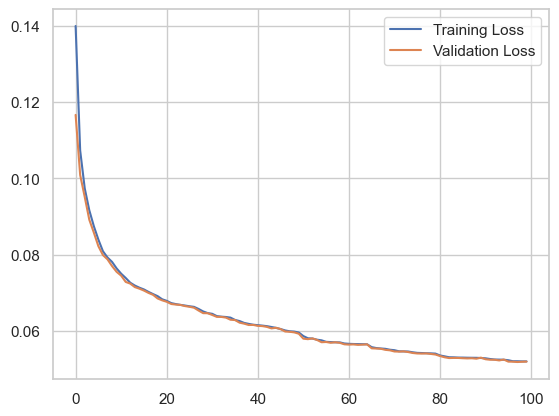

In [128]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step


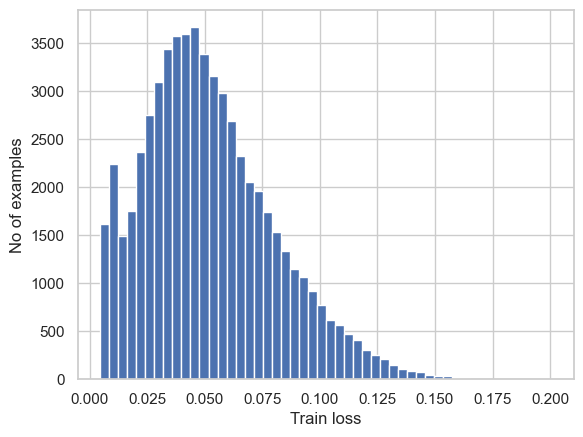

In [131]:
reconstructions = mnist_autoencoder.predict(x_train)
train_loss = tf.keras.losses.mae(reconstructions, x_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [132]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.080228284


In [138]:
preds = predict(mnist_autoencoder, x_train, threshold)
"Number of anomalies:", np.size(preds) - np.count_nonzero(preds), "in total amount of ", np.size(preds)

('Number of anomalies:', 9673, 'in total amount of ', 60000)

Пороговое значение ошибка равно 0.08 и таким образом аномальными считаются около 10000 цифр, что выглядит допустимым с учётом различных почерков.

## Поиск аномалий в "зашумленных" цифрах MNIST

Для более наглядного применения поиска аномалий создадим "аномальные" цифры: отделим 1000 цифр, которые покроем шумом и таким образом сделаем аномальными.

In [211]:
anomalous_mnist = np.copy(x_train[:1000])
normal_mnist = np.copy(x_train[1000:])

anomalous_mnist.shape, normal_mnist.shape

((1000, 784), (59000, 784))

In [212]:
anomalous_mnist_before = np.copy(anomalous_mnist) # for comparison

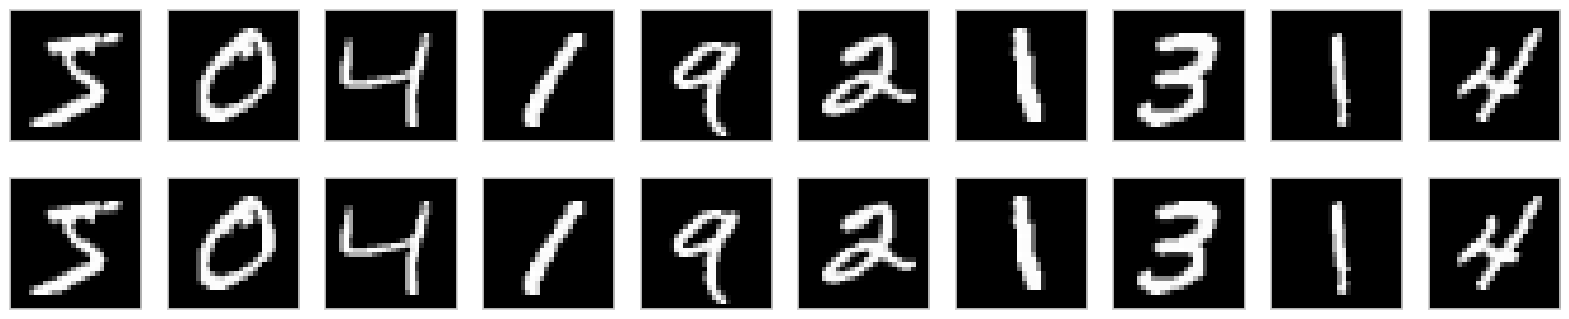

In [213]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(anomalous_mnist_before[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(anomalous_mnist[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Применение шума к аномальным цифрам

In [214]:
for digit in anomalous_mnist:
    for i in range(len(digit) - 1):
        digit[i] = min(1, digit[i+1]+np.random.random_sample() * 0.25 + 0.4)

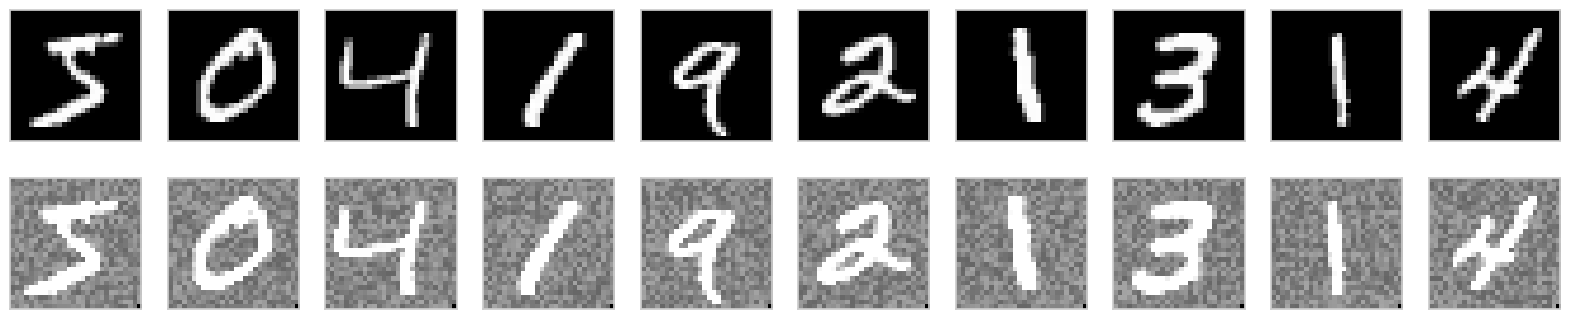

In [215]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(anomalous_mnist_before[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(anomalous_mnist[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Создание датасета и разделение на обучающую и тестовую выборки (содержащие как нормальные так и аномальные)

In [247]:
mnist_labels = np.array([0] * len(anomalous_mnist) + [1] * len(normal_mnist)) # labels set

mnist_labels.size, mnist_labels[995:1005]

(60000, array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))

#### Разделение на тренировочную и тестовую выборки нормальных цифр (аномальные не используются для обучения)

In [249]:
mnist_data = np.concatenate((anomalous_mnist, normal_mnist), axis=0)
mnist_data.shape

(60000, 784)

In [251]:
mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test = train_test_split(
    mnist_data, mnist_labels, test_size=0.2, random_state=37
)

mnist_x_train.shape, mnist_x_test.shape

((48000, 784), (12000, 784))

### Поиск аномалий (для него можно использовать обученный выше автоэнкодер)

1844/1844 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step


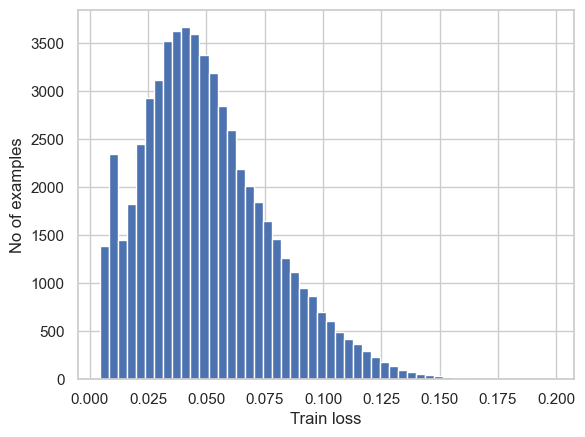

In [252]:
reconstructions = mnist_autoencoder.predict(normal_mnist)
train_loss = tf.keras.losses.mae(reconstructions, normal_mnist)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


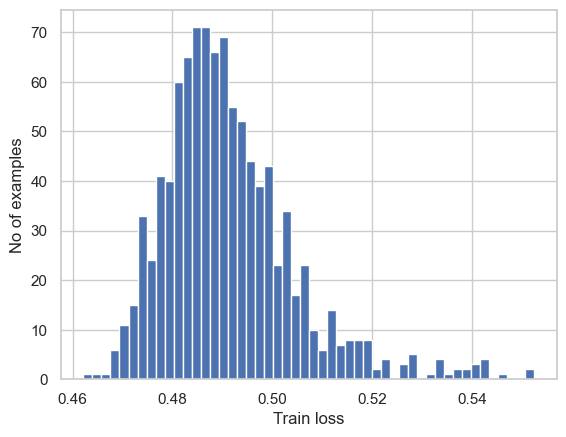

In [253]:
reconstructions = mnist_autoencoder.predict(anomalous_mnist)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_mnist)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [254]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.5044829


In [258]:
preds = predict(mnist_autoencoder, mnist_x_test, threshold)
print_stats(preds, mnist_y_test)

Accuracy = 0.9855833333333334
Precision = 0.985559265442404
Recall = 1.0


In [283]:
reconstructions = mnist_autoencoder.predict(x_train)
train_loss = tf.keras.losses.mae(reconstructions, x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step


## Определение 10 лучших и 10 худших цифр среди всех цифр

In [284]:
train_loss = np.array(train_loss)
train_loss.shape

(60000,)

In [285]:
indices = np.argsort(train_loss)

In [286]:
best_indices = indices[:10]
worst_indices = indices[len(train_loss) - 10:]

In [287]:
best_images = []
worst_images = []

for i in best_indices:
    best_images.append(x_train[i])

for i in worst_indices:
    worst_images.append(x_train[i])

In [295]:
# проверка

best_mae = []
worst_mae = []

for i in best_indices:
    best_mae.append(train_loss[i])

for i in worst_indices:
    worst_mae.append(train_loss[i])

best_indices, best_mae, worst_indices, worst_mae

(array([51908,  1680, 14734, 29214,  3714, 32597, 39716,  1458, 52648,
        55080]),
 [0.0044690697,
  0.0050104726,
  0.0051917234,
  0.0052905823,
  0.0054740924,
  0.005505902,
  0.005514824,
  0.005565727,
  0.0055923536,
  0.0056227543],
 array([55048, 22752,  3106, 16921, 59439, 46344, 25285, 41358, 25321,
        59452]),
 [0.16684926,
  0.1673526,
  0.16909409,
  0.17387967,
  0.17511153,
  0.17511299,
  0.1751913,
  0.17722169,
  0.18617535,
  0.19784094])

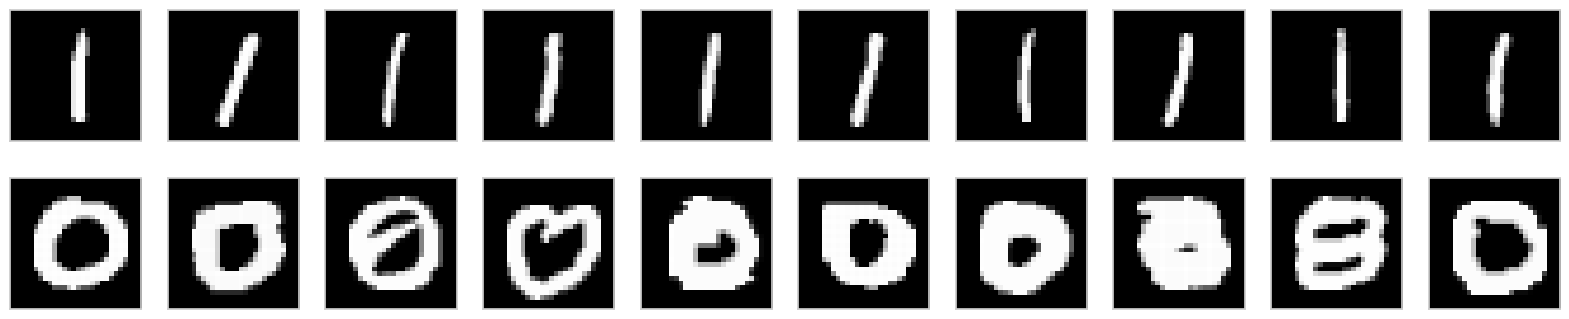

In [278]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(best_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(worst_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Определение 10 лучших и 10 худших цифр для каждой цифры

In [348]:
def find_10_best_and_worst(data):
    reconstructions = mnist_autoencoder.predict(data)
    train_loss = tf.keras.losses.mae(reconstructions, data)

    train_loss = np.array(train_loss)
    train_loss.shape

    indices = np.argsort(train_loss)

    best_indices = indices[:10]
    worst_indices = indices[len(train_loss) - 10:]

    best_images = []
    worst_images = []
    
    for i in best_indices:
        best_images.append(data[i])
    
    for i in worst_indices:
        worst_images.append(data[i])

    return (best_images, worst_images)
    

### Выделение 10 подмножеств для каждой цифры

In [349]:
x_train.shape, y_train.shape

((60000, 784), (60000,))

In [350]:
x_train_by_digit = [x_train[y_train == i] for i in range(10)]
for d_set in x_train_by_digit:
    print(d_set.shape)

(5923, 784)
(6742, 784)
(5958, 784)
(6131, 784)
(5842, 784)
(5421, 784)
(5918, 784)
(6265, 784)
(5851, 784)
(5949, 784)


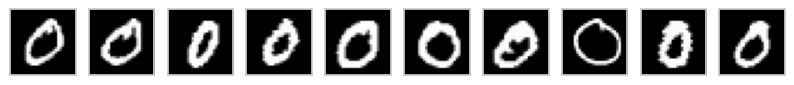

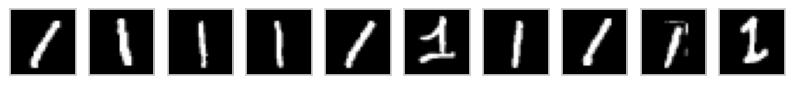

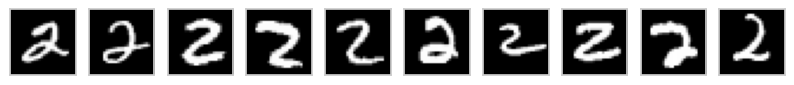

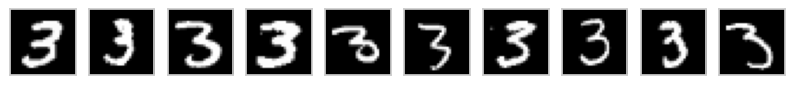

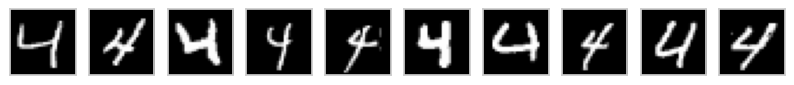

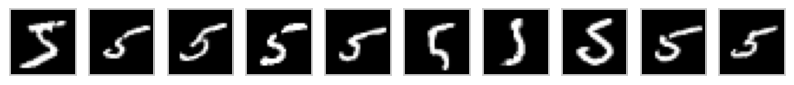

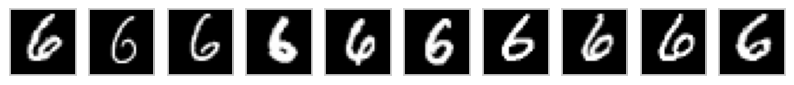

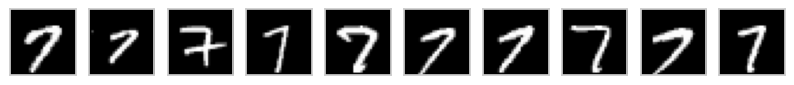

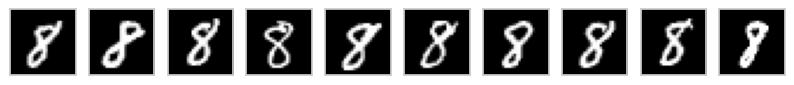

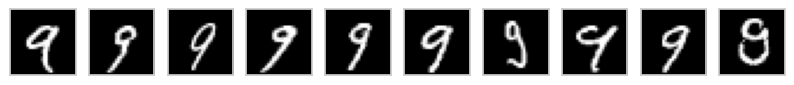

In [360]:
n = 10  # How many digits we will display

for j in range(10):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_train_by_digit[j][i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [352]:
def compare_best_worst(best_images_set, worst_images_set):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(best_images_set[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(worst_images_set[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [353]:
best_in_classes = []
worst_in_classes = []

for subset in x_train_by_digit:
    best, worst = find_10_best_and_worst(subset)
    best_in_classes.append(best)
    worst_in_classes.append(worst)

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


In [354]:
len(best_in_classes[0])

10

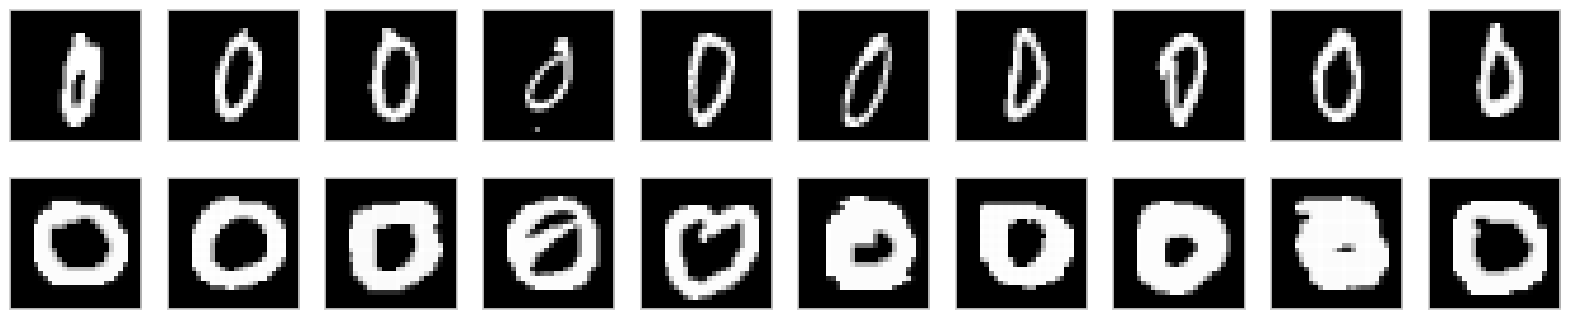

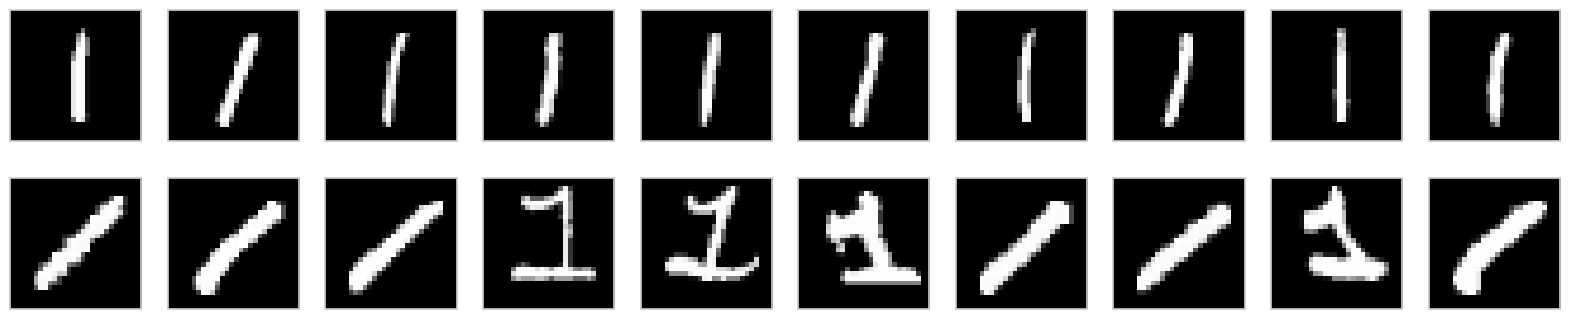

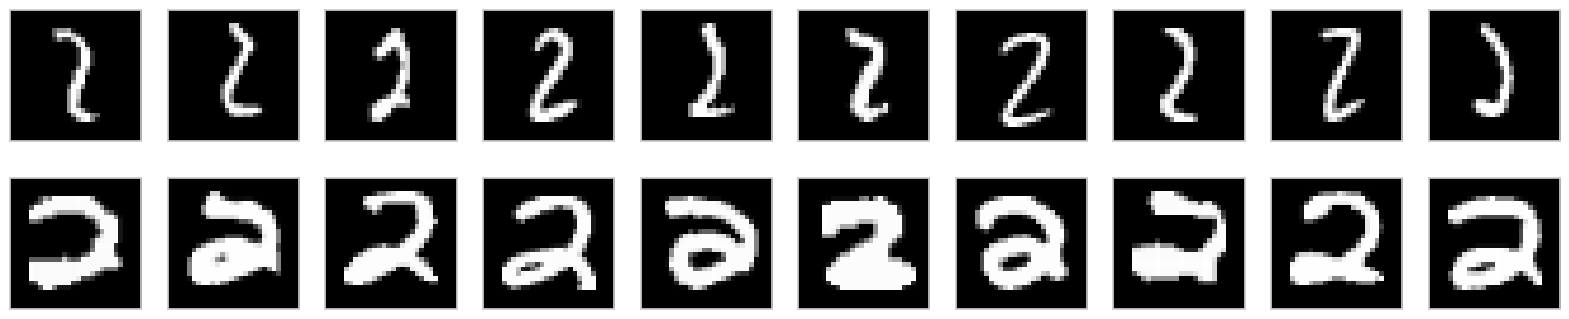

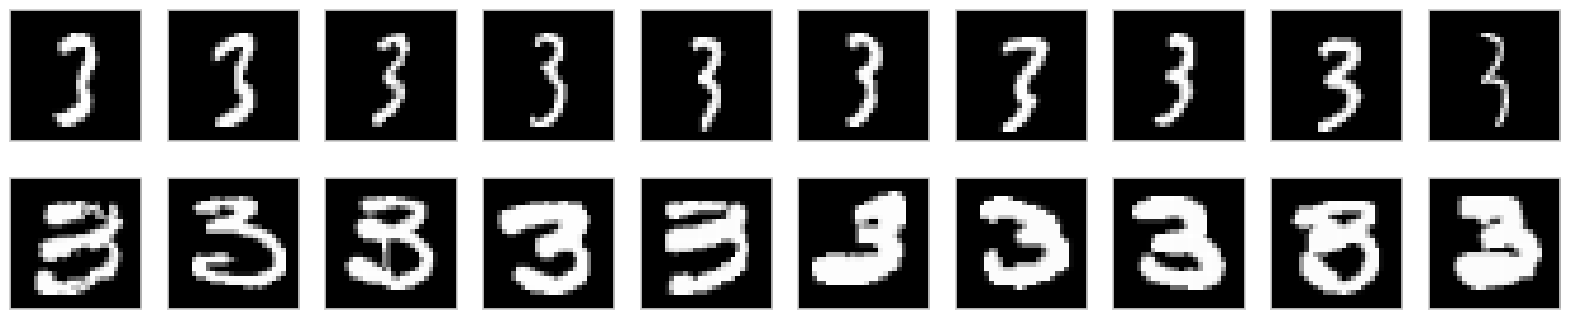

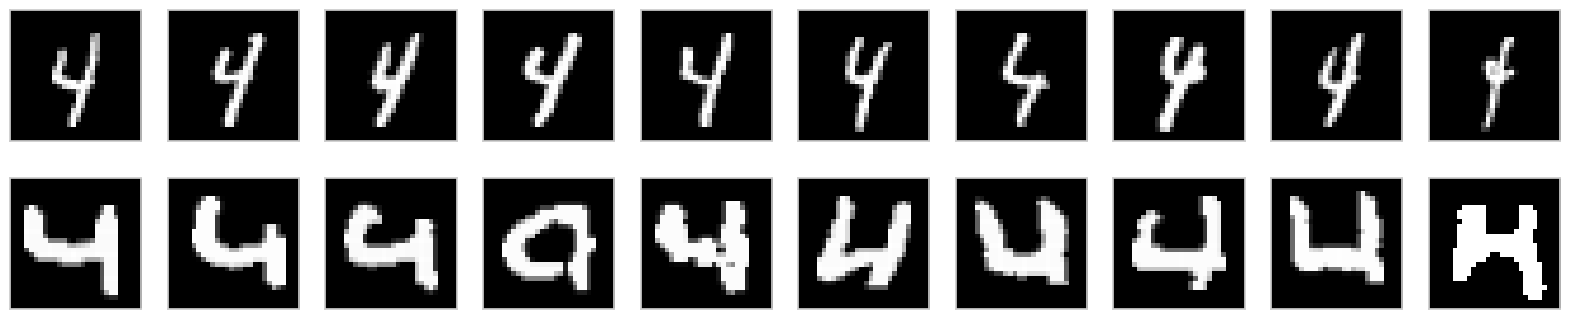

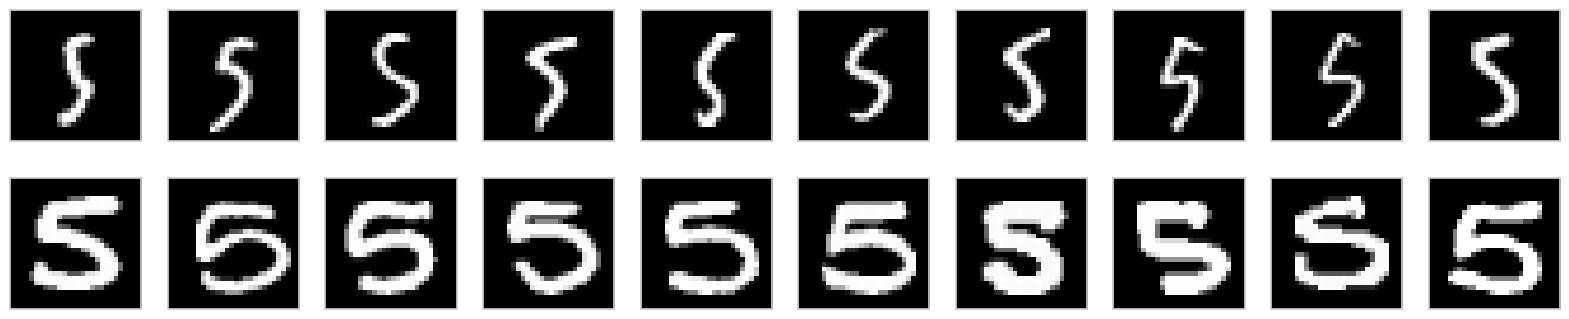

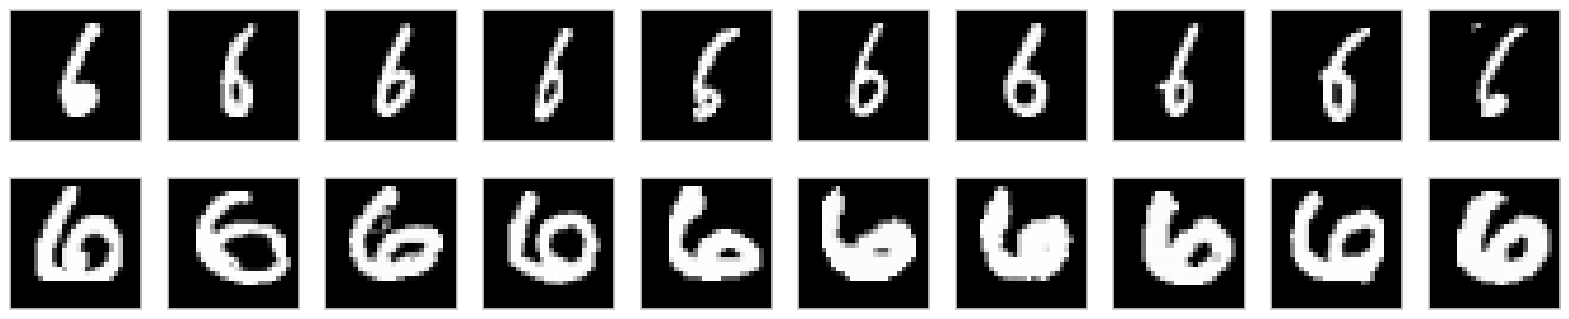

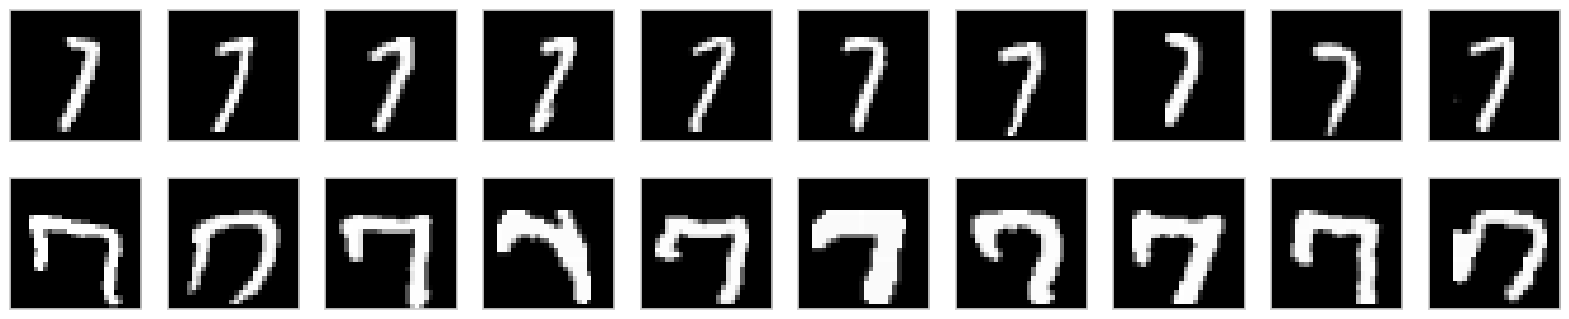

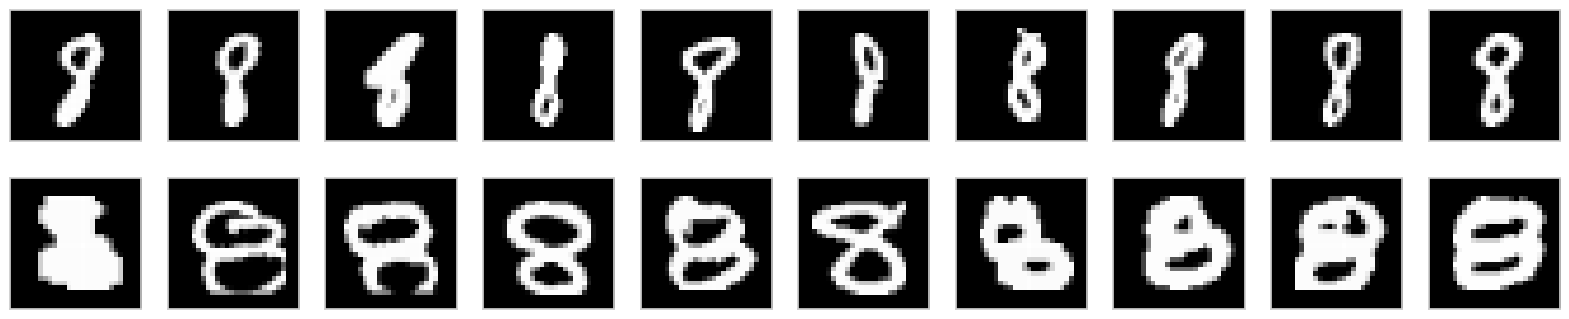

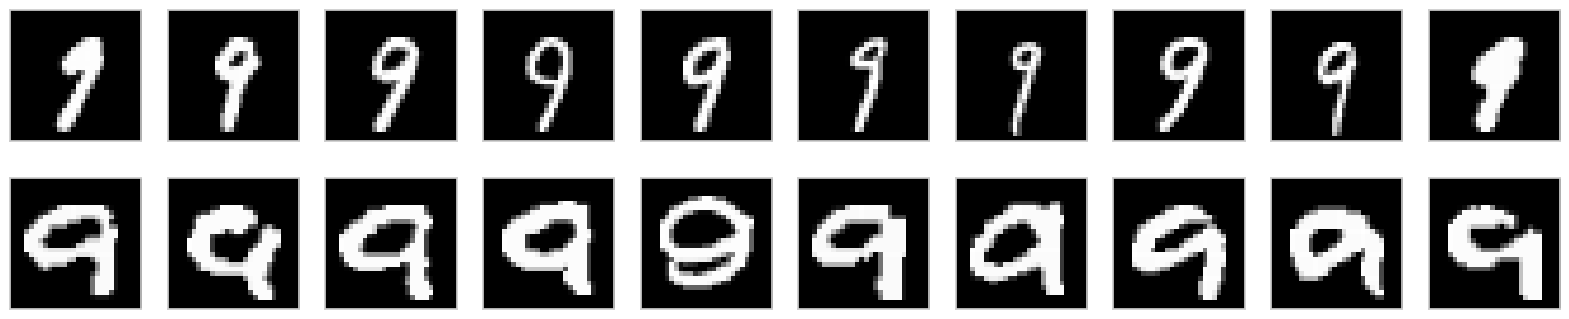

In [356]:
for i in range(10):
    compare_best_worst(best_in_classes[i], worst_in_classes[i])


### Boxplot для каждой цифры

In [363]:
maes_per_digits = pd.DataFrame({'MAE': train_loss, 'Digit': y_train})

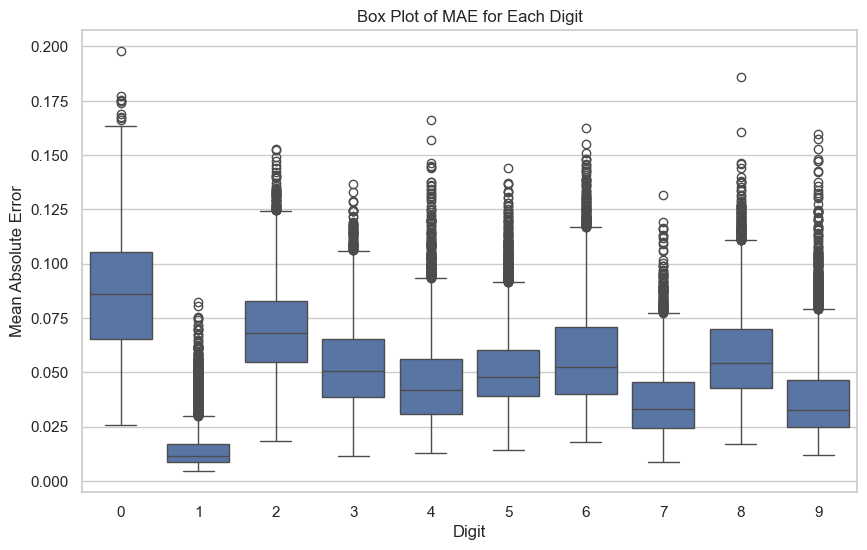

In [364]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Digit', y='MAE', data=maes_per_digits)
plt.title('Box Plot of MAE for Each Digit')
plt.xlabel('Digit')
plt.ylabel('Mean Absolute Error')
plt.show()

In [365]:
reconstructions_test = mnist_autoencoder.predict(x_test)
test_loss = tf.keras.losses.mae(reconstructions_test, x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [366]:
maes_test_per_digits = pd.DataFrame({'MAE': test_loss, 'Digit': y_test})

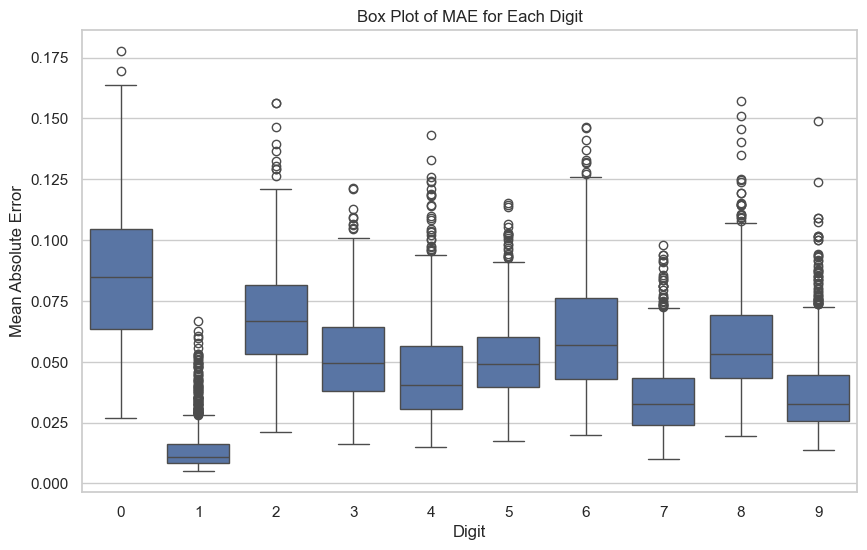

In [367]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Digit', y='MAE', data=maes_test_per_digits)
plt.title('Box Plot of MAE for Each Digit')
plt.xlabel('Digit')
plt.ylabel('Mean Absolute Error')
plt.show()